<a href="https://colab.research.google.com/github/dwjang0902/ExampleNew/blob/master/Data_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

요청 URL = http://finance.naver.com/item/sise_day.nhn?code= 049430


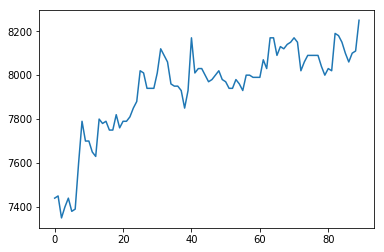

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


<class 'numpy.ndarray'> (90, 6)
[ 7440     0  7300  7450  7300 24125]
<class 'numpy.ndarray'> (90, 6)
[0.01041827 0.         0.01022251 0.01035643 0.01034317 0.01885452]
 length =  88
<class 'numpy.ndarray'> (88, 2, 6)
<class 'numpy.ndarray'> (88, 2, 6)
[[[0.01041827 0.         0.01022251 0.01035643 0.01034317 0.01885452]
  [0.01043227 0.00242131 0.01037655 0.01039813 0.01038567 0.02430572]]]
[[[0.01043227 0.00242131 0.01037655 0.01039813 0.01038567 0.02430572]
  [0.01029224 0.02421308 0.01036255 0.01038423 0.01041401 0.01629734]]]


TypeError: ignored

In [0]:
#---------------------------------------------------------
#주가 데이터 읽어오기
#---------------------------------------------------------
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

tf.reset_default_graph() # 중요한 부분이다; 이것이 없으면 런타임을 항상 리셋 해 주어야 한다.

#-------------------------------------------------------------------------------
# 한국거래소에서 종목코드 가져오기
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 
code_df = code_df[['회사명', '종목코드']]

# 한글로된 컬럼명을 영어로 바꿔준다. 
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'}) 
code_df.head()
#-------------------------------------------------------------------------------


# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와 
# 네이버 금융(http://finance.naver.com)에 넣어줌 
def get_url(item_name, code_df): 
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
    
    print("요청 URL = {}".format(url)) 
    return url, code

# 신라젠의 일자데이터 url 가져오기 

item_name='코메론' 
url, code = get_url(item_name, code_df)
#print(type(code))
# 왜 이렇게 해야 동작하는지 잘 모르겠다.
code = np.int(code)
code = str(code)
code = code.zfill(6)

code_num = code
#print(url)

# 일자 데이터를 담을 df라는 DataFrame 정의 
df = pd.DataFrame()


# 1페이지에서 20페이지의 데이터만 가져오기 
for page in range(1, 10): 
#    pg_url = '{url}&page={page}'.format(url=url, page=page) # 동작을 않는다, 이유를 모르겠다 ???
    pg_url = 'http://finance.naver.com/item/sise_day.nhn?code=' + code_num + '&page='+ str(page)
#    print(pg_url)
#    df = pd.read_html(pg_url)
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
 
# NaN 데이타 제거
df = df.dropna(axis = 0)

# 한글로 된 컬럼명을 영어로 바꿔줌 
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 

# 데이터의 타입을 int형으로 바꿔줌 
#df[['close', 'diff', 'open', 'high', 'low', 'volume']]  = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float) 

# 일자(date)를 기준으로 오름차순 정렬 
df = df.sort_values(by=['date'], ascending=True) 

# 상위 5개 데이터 확인
#print( df.tail(10))

plt.plot(df["close"].to_numpy())
plt.show()

#print(df.dtypes) #object

#------------------------------------------------------------
# 예측하기 by RNN
#------------------------------------------------------------
input_data = df.as_matrix()[:, 1:7].astype(int)
input_data = df.to_numpy()[:, 1:7].astype(int)
print(type(input_data), input_data.shape)
print(input_data[0])


# 데이터 정규화
#-----------------------------
from sklearn.preprocessing import normalize
input_data = normalize(input_data, axis = 0, norm = 'l1') #column normalize
input_data = np.asarray(input_data)
print(type(input_data), input_data.shape)
print(input_data[0])


# RNN 입력데이터 준비
#-------------------------------
def gen_xy_data(input_data, seq_len, pred_step = 1) :
        x_data = []
        y_data = []
        length = input_data.shape[0] - seq_len - pred_step+1
        print(" length = ", length)
        for i in range(length) :
            x = input_data[i:i+seq_len]
            y = input_data[i+pred_step: i+seq_len+pred_step]
            x_data.append(x)
            y_data.append(y)
        return x_data, y_data

seq_len   = 2
pred_step = 1
#x_data = [batch_size, seq_len, input_dim]; y_data = [batch_size, seq_len, output_dim]
x_data, y_data = gen_xy_data(input_data, seq_len, pred_step)
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)
print(type(x_data), x_data.shape)
print(type(y_data), y_data.shape)
print(x_data[0:1])
print(y_data[0:1])

# 데이터 분리(트레이닝, 테스트)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state= None)
#print(len(x_train), len(x_test))

#Parameter
#----------------------------
input_dim = x_train.shape[2] #6
output_dim = 1 # 종가만 예측하는 것으로 한다
seq_len = seq_len
hidden_size = 10

#Model
X = tf.placeholder(tf.float32, [None, seq_len, input_dim])
Y = tf.placeholder(tf.float32, [None, seq_len, output_dim])

# 참조 : https://github.com/tensorflow/tensorflow/issues/16186
def lstm_cell():
   lstm = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=1.0)
   return lstm
cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(3)])
outputs, _states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32) # 출력
#outputs = [batch_size, seq_len, hidden_size  ]

w = tf.Variable(tf.float32, tf.random_normal([output_dim, hidden_size]))
b = tf.Variable(tf.float32, tf.random_normal([output_dim]))
outputs = [tf.matmul(w,outputs) + b for i in outputs]
#[batch_size, seq_len, out_dim]

learning_rate = 0.01

#stacked_rnn_outputs = tf.reshape(outputs, [-1, hidden])
#stacked_outputs = tf.layers.dense(stacked_rnn_outputs , output_dim)
#outputs = tf.reshape(stacked_outputs, [-1, seq_len, output_dim])

loss = tf.reduce_mean(tf.square(outputs - Y[:,:,0]))
#여기서 y는 [:,:,0], 즉 종가만을 예측하는 것으로 한다.

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

"""
epoches = 10000

#---------------------------------------------------------------------------------------
with tf.Session() as sess :
    sess.run(init)
    for ep in range(epoches) :
        sess.run(training_op, feed_dict = { x : x_batches, y: y_batches})
        
        if ep % 100 == 0 :
            mse = loss.eval(feed_dict = { x : x_batches, y: y_batches})
#            print(ep, "\MSE ", mse)

    y_pred = sess.run(outputs, feed_dict = {x:x_test})
#    print(" Prediction = \n ", y_pred)
        
#------------------------------------------------------------------------------------------
plt.title("Forecast vs Actual", fontsize = 14)
plt.plot( pd.Series(np.ravel(y_test)), "bo", markersize = 10, label ="Actual")

plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize = 10, label = "Forecast")
plt.legend(loc = " upper right")
plt.xlabel("Time Periods")
plt.show
        
"""
